# FINE-TUNING ZOOBOT MODELS

This notebook demonstrates finetuning Zoobot.

Finetuning means adapting a model pretrained on a large amount of data (here, many Galaxy Zoo answers) to solve a new problem using a small amount of new data.

We follow these steps:
- Install Zoobot (PyTorch version)
- Download the data to finetune on, starting from that checkpoint and the data to finetune on (ring images and ring label catalog)
- Download a pretrained checkpoint from HuggingFace
- Configure and run the finetuning

For standalone script examples, see zoobot/pytorch/examples/finetuning

In [1]:
# prompt: automatic reload

%load_ext autoreload
%autoreload 2

## Install Zoobot

- If on local computer, need to have installed: pytorch stack, zoobot, fixed version of galaxy-datasets
- If on colab: see below zoobot and its dependencies and fixed version of galaxy-datasets

In [ ]:
raise Exception("Need to run install manually")

In [193]:
!pip install zoobot[pytorch-colab] -q

In [194]:
# Install galaxy-datasets with fix for albumentation>=2.0.0 breaking change where p=1.0 replaces always_apply=True
# https://github.com/albumentations-team/albumentations/releases/tag/2.0.0
!pip install git+https://git@github.com/rmegret/galaxy-datasets.git -q

In [197]:
!pwd

/home/rmegret/galaxy/galaxy-classification/notebooks


In [ ]:
# Get general structure for galaxy-classification
!git clone --depth 1 https://github.com/rmegret/galaxy-classification.git

In [5]:
# Install galaxy_classification as an editable package (assume current directory is notebooks/)
%pip install -e ..

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Obtaining file:///home/rmegret/galaxy/galaxy-classification
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for galaxy_classification (pyproject.toml) ... done
  Created wheel for galaxy_classification: filename=galaxy_classification-0.0.1-py3-none-any.whl size=3110 sha256=95f28162fc968023bc0bd44b50e7ffbe6c7f72721114f7fac5bec1df48d4c47c
  Stored in directory: /tmp/pip-ephem-wheel-cache-0b_t6kby/wheels/af/5f/5f/a631f74b5364151888976d0f119666dd4d32487da0e5500adf
Successfully built galaxy_classification
  Attempting uninstall: galaxy_classification
    Found existing installation: galaxy_classification 0.0.1
    Uninstalling galaxy_classification-0.0.1:
      Successfully uninstalled galaxy_classification-0.0.1
Note: you may need to restart

## Setup

In [2]:
import logging
import os
import sys

import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

In [3]:
import torch
torch.__version__

'2.6.0+cu124'

In [4]:
from zoobot.pytorch.training.finetune import FinetuneableZoobotClassifier
from zoobot.pytorch.predictions import predict_on_catalog

from galaxy_datasets.pytorch.galaxy_datamodule import GalaxyDataModule
from galaxy_classification.transforms import custom_transforms
import albumentations as A

INFO:datasets:PyTorch version 2.6.0 available.


GZDESI/GZRings/GZCD not available from galaxy_datasets.pytorch.datasets - skipping
PROJ_ROOT path is: /home/rmegret/galaxy/galaxy-classification


In [5]:
ROOT_DIR = Path().resolve().parent                   # For local, assumes Path points to galaxy-classification/notebooks directory
# ROOT_DIR = Path('/content/galaxy-classification')  # For colab
DATA_DIR = ROOT_DIR / 'data'
RGB_DATA_DIR = DATA_DIR / 'raw' / 'galaxies-rgb'

RGB_DATA_DIR

PosixPath('/home/rmegret/galaxy/galaxy-classification/data/raw/galaxies-rgb')

### UPR SMOG RGB dataset
Download `galaxies-rgb.tgz` dataset to `DATA_DIR`, then unpack it as `data/raw/galaxies-rgb/`

In [ ]:
!tar -xzvf {DATA_DIR}/galaxies-rgb.tar.gz -C {DATA_DIR / 'raw'}

## Download Catalogs of Images and Labels

Each catalog should be a dataframe with columns of "id_str", "file_loc", and any labels.

The catalog must have:
- Column(s) with your labels e.g. bool `galaxy`.
- `id_str` to identify each row. Can be anything unique.
- `file_loc` column with paths to each image (.jpg, .png and .fits are supported - see the docs)


## Use ready_made splits

In [10]:
# Reload ready made split
catalog = pd.read_csv(RGB_DATA_DIR / 'clean_catalog_manualfix_splits.csv')

catalog['file_loc'] = catalog['file_loc'].apply(lambda x: str(RGB_DATA_DIR / x))   # Redefine file_loc to have full path
catalog.set_index('source_id')

train_catalog = catalog[catalog.train == 1]
test_catalog = catalog[catalog.train == 0]
print(f"Training set size: {len(train_catalog)}")
print(f"Testing set size: {len(test_catalog)}")

label_cols = ['galaxy']

Training set size: 1108
Testing set size: 278


In [7]:
# Check if all files exist
assert all([os.path.isfile(loc) for loc in train_catalog['file_loc']])

### Debug datamodule

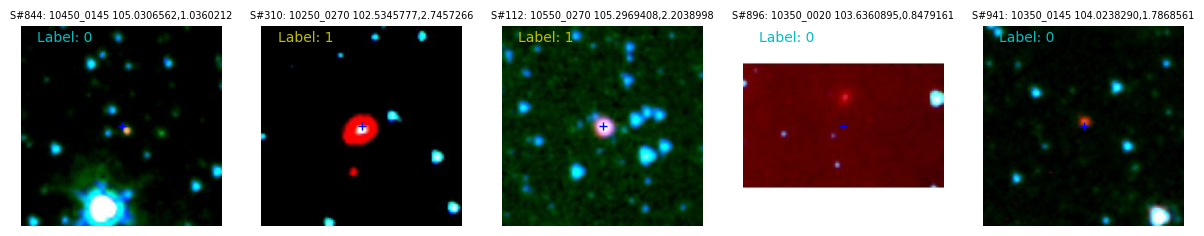

In [9]:
from galaxy_classification.plots import show_crops
df = catalog.sample(5, random_state=7)
show_crops(df, nrows=None, plotfun='label');

In [16]:
transforms = custom_transforms(crop_scale_bounds=(1.0,1.0),resize_after_crop=100)

datamodule = GalaxyDataModule(
    label_cols=label_cols,  # specifying which columns to load as labels with `label_cols`
    catalog=train_catalog,
    train_fraction=0.8,
    val_fraction=0.19,
    test_fraction=0.01,
    batch_size=48,
    resize_after_crop=100,  # the size of the images input to the model
    num_workers=2,  # sets the parallelism for loading data. 2 works well on colab.
    greyscale=False,  # Most Zoobot checkpoints expect color images
    custom_albumentation_transform=transforms,
)
print(datamodule.custom_albumentation_transform)

INFO:root:Num workers: 2
INFO:root:Prefetch factor: 4
INFO:root:Using albumentations transform for augmentations
INFO:root:Using the same custom albumentations transforms for train and test


Compose([
  RemoveAlpha(p=1.0),
  RandomCenteredCrop(p=1.0, size=(100, 100), scale=(1.0, 1.0), rotation=(-180.0, 180.0)),
  VerticalFlip(p=0.5),
  ToFloat(p=1.0, max_value=255.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)


INFO:lightning_fabric.utilities.seed:Seed set to 42


tensor(0.) tensor(1.) torch.Size([48, 3, 100, 100])
tensor(1.)


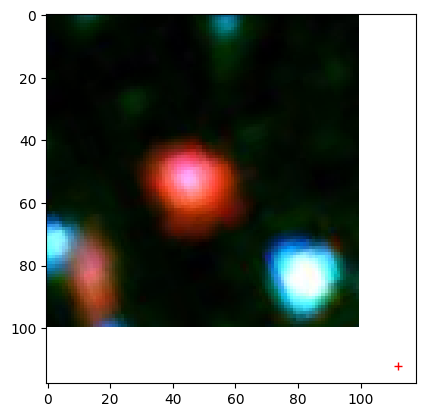

In [48]:
import pytorch_lightning as pl

# just to demonstrate what datamodule returns. you don't need to do this.
datamodule.setup()
pl.seed_everything(42)
for batch in datamodule.train_dataloader():
  images = batch[0]
  labels = batch[1]
  print(images.min(), images.max(), images.shape)
  n = 0
  print(labels[n])
  plt.imshow(images[n].permute(1, 2, 0))
  plt.plot(112,112, '+', color='red')
  break

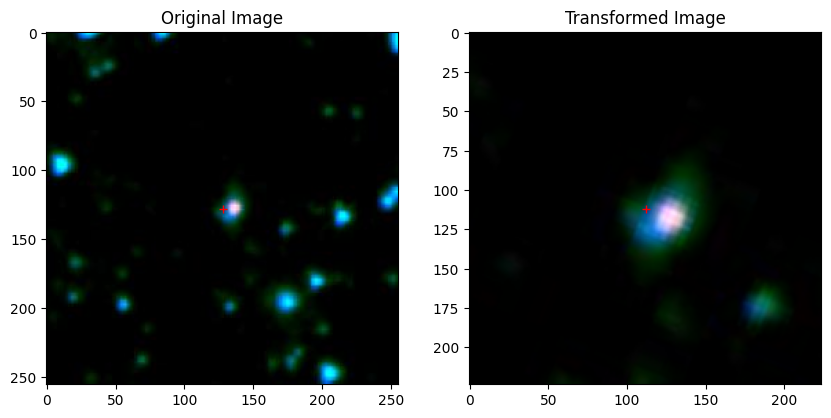

In [18]:
# Test augmentation
import matplotlib.pyplot as plt
from PIL import Image

galaxy = catalog.loc[0]
im = Image.open(galaxy['file_loc'])
im = im.resize((256,256))
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(im)
axes[0].plot(128,128, '+', color='red')
axes[0].set_title('Original Image')
#pl.seed_everything(42)
imaug=custom_transforms(crop_scale_bounds=(2.0,2.0))(image=np.array(im))['image']   # Always same augment
#imaug=transforms(image=np.array(im))['image']    # New augment paramater each time
axes[1].imshow(imaug)
axes[1].plot(112,112, '+', color='red');
axes[1].set_title('Transformed Image');

(70.0, 30.0)

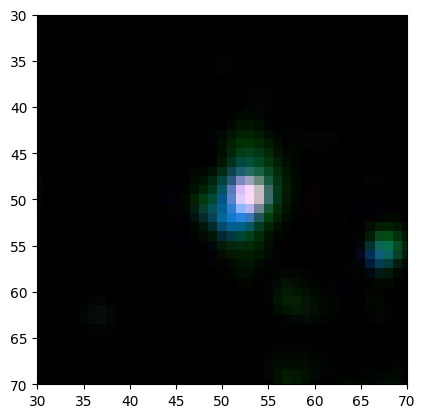

In [62]:
plt.imshow(im)
plt.xlim([128-20,128+20])
plt.ylim([128+20,128-20])
plt.xlim([50-20,50+20])
plt.ylim([50+20,50-20])

(148.0, 108.0)

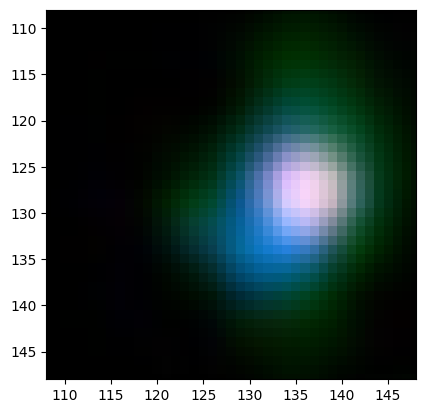

In [68]:
plt.imshow(im.resize((256,256), resample=Image.BILINEAR))
plt.xlim([128-20,128+20])
plt.ylim([128+20,128-20])

(148.0, 108.0)

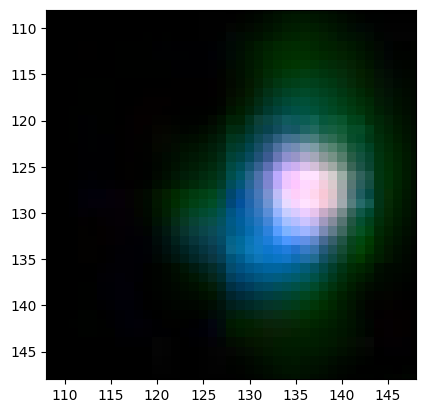

In [57]:
im = Image.open(galaxy['file_loc'])
plt.imshow(im)
plt.xlim([128-20,128+20])
plt.ylim([128+20,128-20])

# Do finetuning

In [19]:
RUN_DIR = DATA_DIR / 'runs' / 'rgb-clean-nano'
RUN_DIR.mkdir(parents=True, exist_ok=True)

In [117]:
#!rm -rf {DATA_DIR / 'runs' / 'rgb-center'}

In [20]:
# Augmentation setup
transforms = custom_transforms(crop_scale_bounds=(1.0,3.0))

In [21]:
# Train dataset
datamodule = GalaxyDataModule(
    label_cols=label_cols,  # specifying which columns to load as labels with `label_cols`
    catalog=train_catalog,
    train_fraction=0.8,
    val_fraction=0.19,
    test_fraction=0.01,
    batch_size=64, # nano: 64 -> 5GB, 128 -> 10GB, 192 -> 15GB
    resize_after_crop=224,  # the size of the images input to the model
    num_workers=2,  # sets the parallelism for loading data. 2 works well on colab.
    greyscale=False,  # Most Zoobot checkpoints expect color images
    custom_albumentation_transform=transforms,
)
print(datamodule.custom_albumentation_transform)
A.save(datamodule.custom_albumentation_transform, RUN_DIR / 'transform.yaml', 'yaml')

INFO:root:Num workers: 2
INFO:root:Prefetch factor: 4
INFO:root:Using albumentations transform for augmentations
INFO:root:Using the same custom albumentations transforms for train and test


Compose([
  RemoveAlpha(p=1.0),
  RandomCenteredCrop(p=1.0, size=(224, 224), scale=(1.0, 3.0), rotation=(-180.0, 180.0)),
  VerticalFlip(p=0.5),
  ToFloat(p=1.0, max_value=255.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)


In [24]:
model = FinetuneableZoobotClassifier(
    # arguments for any FinetuneableZoobot class
    # there are many options for customizing finetuning. See the FinetuneableZoobotAbstract docstring.
    name='hf_hub:mwalmsley/zoobot-encoder-convnext_nano',  # name of the model to load from the Hugging Face model hub
    n_blocks=5,  # Finetune this many blocks. Set 0 for only the head. Set e.g. 1, 2 to finetune deeper (5 max for convnext).
    learning_rate=2e-5,  # use a low learning rate
    lr_decay=0.5,  # reduce the learning rate from lr to lr^0.5 for each block deeper in the network

    # arguments specific to FinetuneableZoobotClassifier
    num_classes=2
)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (mwalmsley/zoobot-encoder-convnext_nano)
INFO:root:Using classification head and cross-entropy loss
INFO:root:num_classes: 2
INFO:root:Using binary classification


In [ ]:
#model = FinetuneableZoobotClassifier.load_from_checkpoint(RUN_DIR / 'checkpoints' / '17.ckpt')

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (mwalmsley/zoobot-encoder-convnext_nano)
INFO:root:Using classification head and cross-entropy loss
INFO:root:num_classes: 2
INFO:root:Using binary classification


In [23]:
# TRAIN
from zoobot.pytorch.training.finetune import get_trainer
print(f'BEGIN TRAINING, RUNDIR={RUN_DIR}')
trainer = get_trainer(RUN_DIR, accelerator='auto', devices='auto', max_epochs=30, log_every_n_steps=1, )
trainer.fit(model, datamodule)

BEGIN TRAINING, RUNDIR=/home/rmegret/galaxy/galaxy-classification/data/runs/rgb-clean-nano


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/home/rmegret/miniconda3/envs/zoobot/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:root:Encoder architecture to finetune: <class 'timm.models.convnext.ConvNeXt'>
INFO:root:possible blocks to tune: 5
I

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 13: 'finetuning/val_loss' reached 0.65008 (best 0.65008), saving model to '/home/rmegret/galaxy/galaxy-classification/data/runs/rgb-clean-nano/checkpoints/0.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 26: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 39: 'finetuning/val_loss' reached 0.64364 (best 0.64364), saving model to '/home/rmegret/galaxy/galaxy-classification/data/runs/rgb-clean-nano/checkpoints/2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 52: 'finetuning/val_loss' reached 0.58123 (best 0.58123), saving model to '/home/rmegret/galaxy/galaxy-classification/data/runs/rgb-clean-nano/checkpoints/3.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 65: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 78: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 91: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 104: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 117: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 130: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 143: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 156: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 169: 'finetuning/val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [31]:
# Deal with out of memory without restartng
del datamodule
del model
del trainer
import gc; gc.collect()
torch.cuda.empty_cache()

RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [15]:
!nvidia-smi

Tue Mar 25 12:16:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.133.07             Driver Version: 572.83         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2070 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   66C    P8              6W /   80W |     218MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Predict on test set

In [180]:
RUN_DIR = DATA_DIR / 'runs' / 'rgb-center'
RUN_DIR

PosixPath('/home/rmegret/galaxy/galaxy-classification/data/runs/rgb-center')

In [16]:
# now we can load the best checkpoint and make predictions
best_checkpoint = trainer.checkpoint_callback.best_model_path
#best_checkpoint = RUN_DIR / 'checkpoints/19.ckpt'
print(best_checkpoint)
finetuned_model = FinetuneableZoobotClassifier.load_from_checkpoint(best_checkpoint)

/home/rmegret/galaxy/galaxy-classification/data/runs/rgb-nano-scale1-3/checkpoints/5.ckpt


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (mwalmsley/zoobot-encoder-convnext_nano)
INFO:root:Using classification head and cross-entropy loss
INFO:root:num_classes: 2
INFO:root:Using binary classification


In [26]:
# Reload transformation setup
from albumentations.augmentations.transforms import Lambda
from galaxy_datasets.transforms import RemoveAlpha
from galaxy_classification.transforms import RandomCenteredCrop

transforms = A.load(RUN_DIR / 'transform.yaml', 'yaml')
print('TRAIN:',transforms)

# Modify a parameter at test time
for t in transforms.transforms:
    if isinstance(t, RandomCenteredCrop):  # Identify the transform by type
        t.scale = [1.7, 1.7]
        t.rotation = [-180.0, -180.0]
    if isinstance(t, A.VerticalFlip):  # Identify the transform by type
        t.p = 0.0
print('TEST:',transforms)

TRAIN: Compose([
  RemoveAlpha(p=1.0),
  RandomCenteredCrop(p=1.0, size=[224, 224], scale=[1.0, 3.0], rotation=[-180.0, 180.0]),
  VerticalFlip(p=0.5),
  ToFloat(p=1.0, max_value=255.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)
TEST: Compose([
  RemoveAlpha(p=1.0),
  RandomCenteredCrop(p=1.0, size=[224, 224], scale=[1.7, 1.7], rotation=[-180.0, -180.0]),
  VerticalFlip(p=0.0),
  ToFloat(p=1.0, max_value=255.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)


In [27]:
from zoobot.pytorch.predictions import predict_on_catalog

_ = predict_on_catalog.predict(
  test_catalog,
  finetuned_model,
  n_samples=1,
  # CAREFUL! For classification, we unpack a single column like [1, 0, 1, 2, ...] into N classes automatically
  # but when making predictions, we make a prediction per class, so (unlike for training) this prediction `label_cols` needs n_classes entries
  # e.g. [class_for_label_0, class_for_label_1, ...
  label_cols=['not_galaxy', 'galaxy'],  # name the output columns
  save_loc = str(RUN_DIR / 'finetuned_predictions.csv'),
  trainer_kwargs={'accelerator': 'gpu'},
  datamodule_kwargs=dict(num_workers=2, batch_size=32, greyscale=False, custom_albumentation_transform=transforms),
)

INFO:root:Num workers: 2
INFO:root:Prefetch factor: 4
INFO:root:Using albumentations transform for augmentations
INFO:root:Using the same custom albumentations transforms for train and test
INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:root:Beginning predictions
INFO:root:Starting at: 2025-03-25 12:52:58
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 9/9 [00:01<00:00,  8.07it/s]


INFO:root:Predictions complete - (285, 2, 1)
INFO:root:Saving predictions to /home/rmegret/galaxy/galaxy-classification/data/runs/rgb-nano-scale1-3/finetuned_predictions.csv
INFO:root:Predictions saved to /home/rmegret/galaxy/galaxy-classification/data/runs/rgb-nano-scale1-3/finetuned_predictions.csv
INFO:root:Completed at: 2025-03-25 12:53:00
INFO:root:Time elapsed: 0:00:01.471231


Let's quickly check if they're any good:

In [28]:
predictions = pd.read_csv( RUN_DIR / 'finetuned_predictions.csv' )
print(predictions.shape[0])
predictions = pd.merge(predictions, test_catalog[['id_str', 'file_loc', 'galaxy']])
predictions.index = test_catalog.index
predictions.head()

285


id_str  not_galaxy_pred  galaxy_pred  \
0   104.7263830,2.0560720_10450_0145         0.307083     0.692917   
4   104.3578369,1.5539122_10450_0145         0.420719     0.579281   
7   104.0930341,1.3333430_10450_0145         0.211086     0.788914   
9   104.8807827,0.9197180_10450_0145         0.180546     0.819454   
11  104.4275534,1.6589155_10450_0145         0.146916     0.853084   

                                             file_loc  galaxy  
0   /home/rmegret/galaxy/galaxy-classification/dat...       1  
4   /home/rmegret/galaxy/galaxy-classification/dat...       1  
7   /home/rmegret/galaxy/galaxy-classification/dat...       1  
9   /home/rmegret/galaxy/galaxy-classification/dat...       1  
11  /home/rmegret/galaxy/galaxy-classification/dat...       1

In [29]:
print('Accuracy:', np.mean(np.around(predictions['galaxy_pred']) == predictions['galaxy']))

Accuracy: 0.7052631578947368


In [55]:
print('Accuracy:', np.mean(np.around(predictions['galaxy_pred']) == predictions['galaxy']))

Accuracy: 0.7052631578947368


In [34]:
print('Accuracy:', np.mean(np.around(predictions['galaxy_pred']) == predictions['galaxy']))

Accuracy: 0.7192982456140351


In [56]:
#import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 0, 'predicted score')

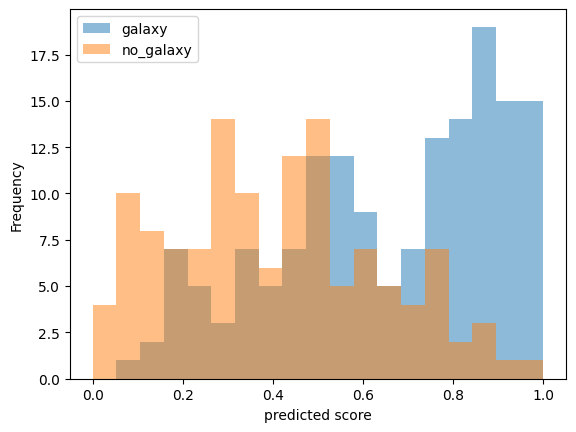

In [57]:
pp = predictions.copy()
pp['galaxy']=pp['galaxy'].astype(float)
pp[pp.galaxy==1]['galaxy_pred'].rename('galaxy').plot.hist(bins=np.linspace(0,1, 20), alpha=0.5);
pp[pp.galaxy==0]['galaxy_pred'].rename('no_galaxy').plot.hist(bins=np.linspace(0,1, 20), alpha=0.5);
plt.legend()
plt.xlabel('predicted score')

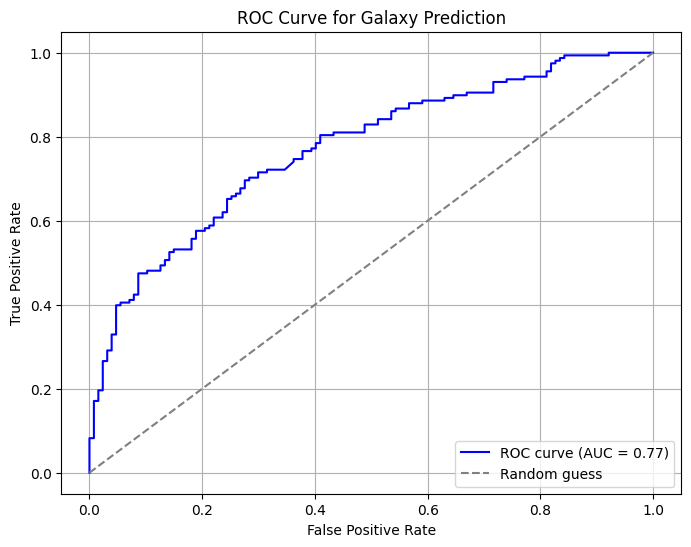

In [58]:
from sklearn.metrics import roc_curve, auc

true_labels = predictions['galaxy'].astype(int)  # Convert boolean to integer
predicted_probs = predictions['galaxy_pred']

fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Galaxy Prediction')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## Predict on training set

In [26]:
# Do same on training to sort out difficulty levels

_ = predict_on_catalog.predict(
  train_catalog,
  finetuned_model,
  n_samples=1,
  # CAREFUL! For classification, we unpack a single column like [1, 0, 1, 2, ...] into N classes automatically
  # but when making predictions, we make a prediction per class, so (unlike for training) this prediction `label_cols` needs n_classes entries
  # e.g. [class_for_label_0, class_for_label_1, ...
  label_cols=['not_galaxy', 'galaxy'],  # name the output columns
  save_loc= str( RUN_DIR / 'finetuned_predictions_train_dataset.csv'),
  trainer_kwargs={'accelerator': 'gpu'},
  datamodule_kwargs=dict(num_workers=2, batch_size=32, greyscale=False, custom_albumentation_transform=transforms),
)

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [110]:
predictions_training = pd.read_csv( RUN_DIR / 'finetuned_predictions_train_dataset.csv' )
print(predictions_training.shape[0])

predictions_training = pd.merge(predictions_training, train_catalog[['id_str', 'file_loc', 'galaxy']])
predictions_training.index = train_catalog.index
print(predictions_training.shape[0])

predictions_training.head()

1140
1140


id_str  not_galaxy_pred  galaxy_pred  \
1  104.1504793,1.3987231_10450_0145         0.113994     0.886006   
2  104.9237340,1.5302104_10450_0145         0.351864     0.648136   
3  104.7788009,1.1385662_10450_0145         0.167127     0.832873   
5  104.8010448,1.6888967_10450_0145         0.123815     0.876185   
6  104.0695201,1.9894318_10450_0145         0.061254     0.938746   

                                            file_loc  galaxy  
1  /content/galaxy-classification/data/raw/galaxi...       1  
2  /content/galaxy-classification/data/raw/galaxi...       1  
3  /content/galaxy-classification/data/raw/galaxi...       1  
5  /content/galaxy-classification/data/raw/galaxi...       1  
6  /content/galaxy-classification/data/raw/galaxi...       1

## Display results

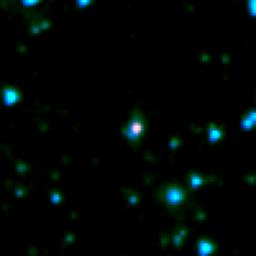

In [ ]:
im = Image.open(test_catalog.iloc[0]['file_loc'])
im.width

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def show_rings(df, nrows=None, ncols=5):
  # little utility function to visualise galaxies and our ring labels/predictions

  N = df.shape[0]
  #print(N)
  if (nrows is None):
    nrows = (N+ncols-1)//ncols
  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))
  axes = axes.ravel()
  for n in range(ncols*nrows):
    axes[n].axis('off')
    if (n>=N): continue;
    galaxy = df.iloc[n]

    im = Image.open(galaxy['file_loc'])
    axes[n].imshow(im)

    h,w = im.height, im.width

    correct = np.around(galaxy['galaxy_pred']) == galaxy['galaxy']
    if correct:
      color = 'g'
    else:
      color = 'r'
    axes[n].text(20, 30, 'Pred: {:.2f}'.format(galaxy['galaxy_pred']), color=color)
    axes[n].text(20, 60, 'Label: {}'.format(galaxy['galaxy']), color=color)
    axes[n].plot([130,230],[20,20],color=color)
    axes[n].plot([130+100*galaxy['galaxy']],[25],'^',color='g')
    axes[n].plot([130+100*galaxy['galaxy_pred']],[20],'o',color=color)
    axes[n].text(130, 40, 'Err {:.2f}'.format(abs(galaxy['galaxy']-galaxy['galaxy_pred'])), color=color)
    axes[n].text(10,240, galaxy['id_str'], color=color, size=7)
    axes[n].set_title(f"#{int(galaxy.name)}: {galaxy['id_str']}", size=7)
    axes[n].plot(w/2,h/2,'b+')
  return fig, axes

In [2]:
item = predictions.iloc[0]

NameError: name 'predictions' is not defined

### Display sampled predictions

In [101]:
predictions[predictions.id_str=='103.4392291,1.5044159_10350_0145']

id_str  not_galaxy_pred  galaxy_pred  \
48  103.4392291,1.5044159_10350_0145         0.008982     0.991018   

                                             file_loc  galaxy  
48  /content/galaxy-classification/data/raw/galaxi...       1

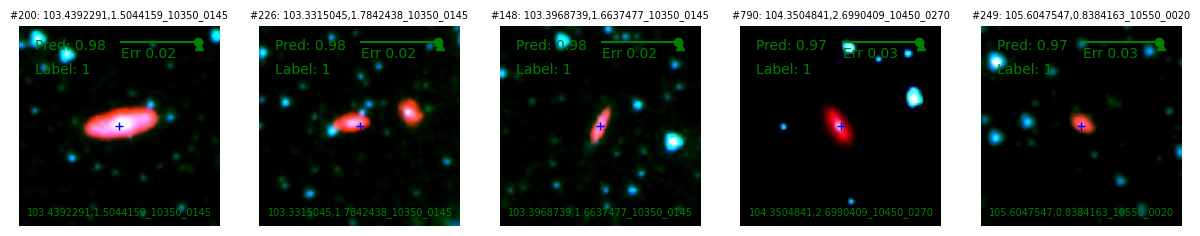

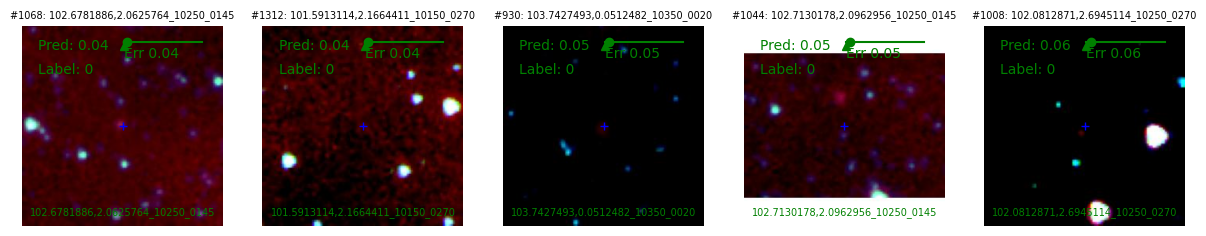

In [41]:
top_predictions = predictions.sort_values('galaxy_pred', ascending=False)
show_rings(top_predictions, nrows = 1)

bottom_predictions = predictions.sort_values('galaxy_pred', ascending=True)
show_rings(bottom_predictions, nrows = 1);

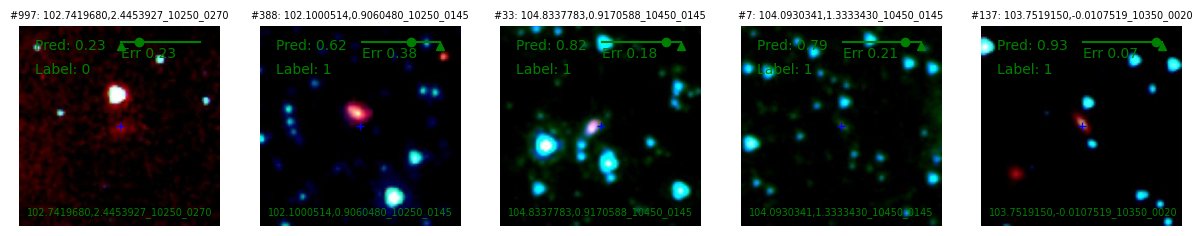

In [42]:
random_predictions = predictions.sample(5)
show_rings(random_predictions, nrows=1);

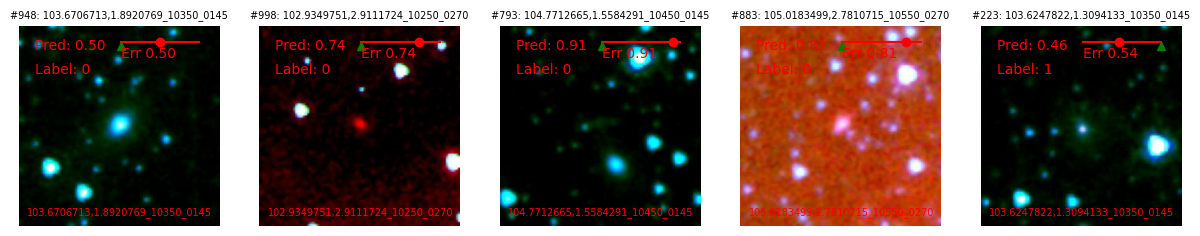

In [113]:
wrong_predictions = predictions.loc[(predictions['galaxy_pred']>0.5) != predictions['galaxy']]
random_predictions = wrong_predictions.sample(5)
show_rings(random_predictions);
#print(random_predictions['id_str'])

### Generate PDF files of all predictions

In [32]:
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm

pdf_filename = RUN_DIR / "predictions_test.pdf"

predictions_sorted = predictions.sort_values('galaxy_pred', ascending=False)
N = predictions_sorted.shape[0]
n_per_page = 25
k_pages = (N+n_per_page-1)//n_per_page
#k_pages = 1
with PdfPages(pdf_filename) as pdf:
  for k in tqdm(range(k_pages)):
    n1 = k*n_per_page
    fig, axes = show_rings(predictions_sorted.iloc[n1:], nrows=5, ncols=8)
    #print(top_5_predictions['id_str'])
    fig.suptitle(f'TEST DATA: Sorted by prediction score - Page {k+1}/{k_pages} - {n1}..{min(N,n1+n_per_page-1)}/0..{N-1}', fontsize=16)
    fig.tight_layout()
    pdf.savefig()
    plt.close()

100%|██████████| 12/12 [00:26<00:00,  2.25s/it]


In [ ]:
pdf_filename = RUN_DIR / "predictions_test_error.pdf"

p_df = predictions.copy()
p_df['pred_error'] = np.abs(p_df['galaxy']-p_df['galaxy_pred'])
predictions_sorted = p_df.sort_values('pred_error', ascending=False)
N = predictions_sorted.shape[0]
n_per_page = 25
k_pages = (N+n_per_page-1)//n_per_page
#k_pages = 1
with PdfPages(pdf_filename) as pdf:
  for k in tqdm(range(k_pages)):
    n1 = k*n_per_page
    fig, axes = show_rings(predictions_sorted.iloc[n1:], nrows=5, ncols=8)
    #print(top_5_predictions['id_str'])
    fig.suptitle(f'TEST DATA: Sorted by prediction error - {k+1}/{k_pages} - {n1}..{min(N,n1+n_per_page-1)}/0..{N-1}', fontsize=16)
    fig.tight_layout()
    pdf.savefig()
    plt.close()

100%|██████████| 12/12 [00:25<00:00,  2.10s/it]


In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm

# Save predictions on training sorted by score

pdf_filename = RUN_DIR / "predictions_training.pdf"

predictions_sorted = predictions_training.sort_values('galaxy_pred', ascending=False)
N = predictions_sorted.shape[0]
n_per_page = 25
k_pages = (N+n_per_page-1)//n_per_page
#k_pages = 1
with PdfPages(pdf_filename) as pdf:
  for k in tqdm(range(k_pages)):
    n1 = k*n_per_page
    fig, axes = show_rings(predictions_sorted.iloc[n1:], nrows=5, ncols=8)
    #print(top_5_predictions['id_str'])
    fig.suptitle(f'TRAIN DATA - Sorted by prediction score - Page {k+1}/{k_pages} - {n1}..{min(N,n1+n_per_page-1)}/0..{N-1}', fontsize=16)
    fig.tight_layout()
    pdf.savefig()
    plt.close()

In [34]:
# Prepare results for download
!cd /content/galaxy-classification/data/; zip -r /content/galaxy-classification/data/runs.zip runs/

  adding: runs/ (stored 0%)
  adding: runs/rgb-center/ (stored 0%)
  adding: runs/rgb-center/checkpoints/ (stored 0%)
  adding: runs/rgb-center/checkpoints/12.ckpt (deflated 7%)
  adding: runs/rgb-center/finetuned_predictions.csv (deflated 58%)
  adding: runs/rgb-center/predictions_test.pdf (deflated 0%)
  adding: runs/rgb-center/transform.yaml (deflated 49%)
  adding: runs/rgb-center/finetuned_predictions_train_dataset.csv (deflated 59%)


# Dim reduction visualization

In [25]:
from zoobot.pytorch.training import representations

In [30]:
RUN_DIR = DATA_DIR / 'runs' / 'rgb-nano-scale1-3'

In [32]:
finetuned_model = FinetuneableZoobotClassifier.load_from_checkpoint(RUN_DIR / 'checkpoints' / '17.ckpt')

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (mwalmsley/zoobot-encoder-convnext_nano)
INFO:root:Using classification head and cross-entropy loss
INFO:root:num_classes: 2
INFO:root:Using binary classification


In [33]:
embedder = representations.ZoobotEncoder(encoder=finetuned_model.encoder)

INFO:root:ZoobotEncoder: using provided in-memory encoder


In [34]:
# Reload transformation setup
from albumentations.augmentations.transforms import Lambda
from galaxy_datasets.transforms import RemoveAlpha
from galaxy_classification.transforms import RandomCenteredCrop

transforms = A.load(RUN_DIR / 'transform.yaml', 'yaml')
print('TRAIN:',transforms)

# Modify a parameter at test time
for t in transforms.transforms:
    if isinstance(t, RandomCenteredCrop):  # Identify the transform by type
        t.scale = [1.7, 1.7]
        t.rotation = [-180.0, -180.0]
    if isinstance(t, A.VerticalFlip):  # Identify the transform by type
        t.p = 0.0
print('TEST:',transforms)

TRAIN: Compose([
  RemoveAlpha(p=1.0),
  RandomCenteredCrop(p=1.0, size=[224, 224], scale=[1.0, 3.0], rotation=[-180.0, 180.0]),
  VerticalFlip(p=0.5),
  ToFloat(p=1.0, max_value=255.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)
TEST: Compose([
  RemoveAlpha(p=1.0),
  RandomCenteredCrop(p=1.0, size=[224, 224], scale=[1.7, 1.7], rotation=[-180.0, -180.0]),
  VerticalFlip(p=0.0),
  ToFloat(p=1.0, max_value=255.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)


In [35]:
embeddings = predict_on_catalog.predict(
        test_catalog,
        embedder,
        n_samples=1,
        label_cols=label_cols,
        save_loc= str( RUN_DIR / 'finetuned_embeddings.hdf5'),
        trainer_kwargs={'accelerator': 'gpu'},
        datamodule_kwargs=dict(num_workers=2, batch_size=32, greyscale=False, custom_albumentation_transform=transforms),
    )

INFO:root:Num workers: 2
INFO:root:Prefetch factor: 4
INFO:root:Using albumentations transform for augmentations
INFO:root:Using the same custom albumentations transforms for train and test


INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:root:Beginning predictions
INFO:root:Starting at: 2025-03-27 22:55:17
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:root:Predictions complete - (278, 640, 1)
INFO:root:Saving predictions to /home/rmegret/galaxy/galaxy-classification/data/runs/rgb-nano-scale1-3/finetuned_embeddings.hdf5
INFO:root:Saving predictions to /home/rmegret/galaxy/galaxy-classification/data/runs/rgb-nano-scale1-3/finetuned_embeddings.hdf5
INFO:root:Predictions saved to /home/rmegret/galaxy/galaxy-classification/data/runs/rgb-nano-scale1-3/finetuned_embeddings.hdf5
INFO:root:Completed at: 2025-03-27 22:55:19
INFO:root:Time elapsed: 0:00:01.664547


In [36]:
embeddings = embeddings.reshape(278, 640)

In [37]:
from umap import UMAP

umap_2d = UMAP(random_state=0)
umap_2d.fit(embeddings)

/home/rmegret/miniconda3/envs/zoobot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/rmegret/miniconda3/envs/zoobot/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(n_jobs=1, random_state=0, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [38]:
Y = umap_2d.transform(embeddings)

/home/rmegret/miniconda3/envs/zoobot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


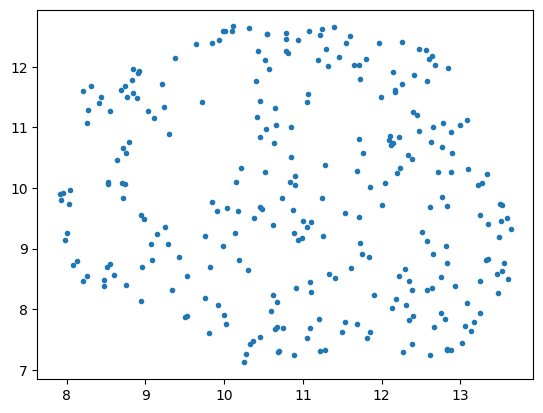

In [39]:
plt.plot(Y[:, 0], Y[:, 1], '.')

In [ ]:
from galaxy_classification.embedding_plots import plot_embeddings_plotly

plot_embeddings_plotly(test_catalog, Y)

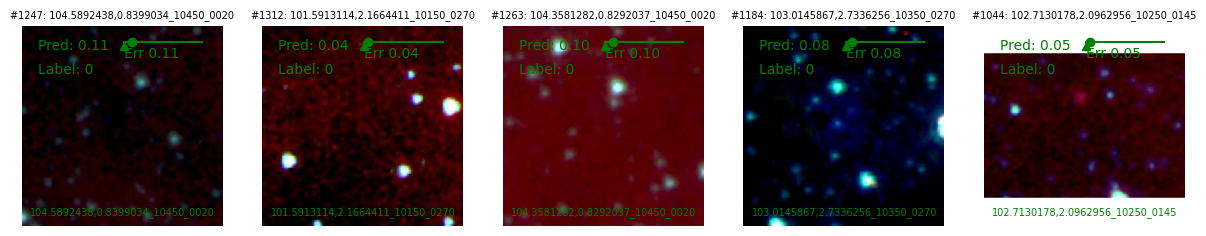

In [34]:
ids = np.argsort(Y[:,0])[::-1]
P = predictions.iloc[ids]
show_rings(P, nrows = 1);

# Estimate precise center of source

In [ ]:
import numpy as np
from PIL import Image

# Assuming `im` is a PIL image
im_array = np.array(im)
print(im_array.shape)  # This will give the dimensions of the image

(148.0, 108.0)

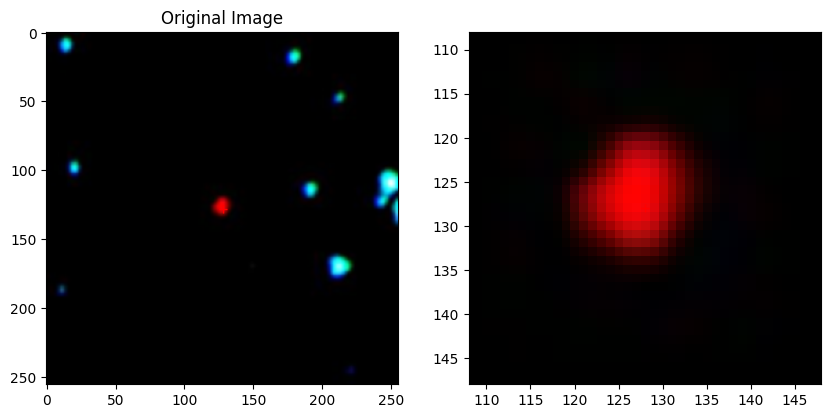

In [162]:
galaxy = catalog.loc[1000]
im = Image.open(galaxy['file_loc'])
im = im.resize((100,100))
im = im.resize((256,256))
im = np.array(im)

im[:,:,0] = im[:,:,0]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(im)
axes[0].plot(128,128, '+', color='red')
axes[0].set_title('Original Image')
#pl.seed_everything(42)

axes[1].imshow(im)
axes[1].plot(128,128, '+', color='red');
axes[1].set_xlim([128-20,128+20])
axes[1].set_ylim([128+20,128-20])

In [89]:
import astropy as ap

In [147]:
from photutils.detection import find_peaks
from astropy.modeling import models, fitting
import numpy as np
from matplotlib.patches import Ellipse

def refine_center(img, refine=False):

  # Assuming `im` is your intensity image (2D numpy array)
  # Normalize the image to [0, 1]
  normalized_im = img / np.max(img[128-20:128+20, 128-20:128+20])

  # Threshold at 0.5 of the max value
  threshold = 0.5
  peaks = find_peaks(normalized_im, threshold=threshold, )
  if (peaks is None) or (len(peaks) == 0):
    return None
    #raise ValueError("No bright blob found in the image.")
  sqdist = np.sqrt((peaks['x_peak'] - 128)**2 + (peaks['y_peak'] - 128)**2)
  idx = np.argmin( sqdist )
  approx_center = (peaks['x_peak'][idx], peaks['y_peak'][idx])

  if (refine):
    # Define a small region around the approximate center for fitting
    x_min, x_max = int(approx_center[0] - 20), int(approx_center[0] + 20)
    y_min, y_max = int(approx_center[1] - 20), int(approx_center[1] + 20)
    sub_image = normalized_im[y_min:y_max, x_min:x_max]

    # Create a grid for the sub-image
    y, x = np.mgrid[y_min:y_max, x_min:x_max]

    # Fit a 2D Gaussian model
    gaussian_init = models.Gaussian2D(amplitude=np.max(sub_image),
                      x_mean=approx_center[0],
                      y_mean=approx_center[1],
                      x_stddev=5,
                      y_stddev=5,
                      theta=0)
    fitter = fitting.LevMarLSQFitter()

    try:
      gaussian_fit = fitter(gaussian_init, x, y, sub_image)
    except Exception as e:
      print(e)
      return None

    # Extract the fitted parameters
    x_center, y_center = gaussian_fit.x_mean.value, gaussian_fit.y_mean.value
    x_std, y_std = gaussian_fit.x_stddev.value, gaussian_fit.y_stddev.value
    theta = gaussian_fit.theta.value

    # Define the ellipse parameters
    a = 2 * x_std  # Semi-major axis
    b = 2 * y_std  # Semi-minor axis

    center = (x_center, y_center)
    return dict(approx_center=approx_center, center=center, ellipse=dict(x_std=x_std, y_std=y_std, theta=theta, a=a, b=b))
  else:
    center = approx_center
    x_std, y_std = 5,5
    theta=0
    a = 2 * x_std
    b = 2 * y_std
    return dict(approx_center=approx_center, center=center, ellipse=dict(x_std=x_std, y_std=y_std, theta=theta, a=a, b=b))

  

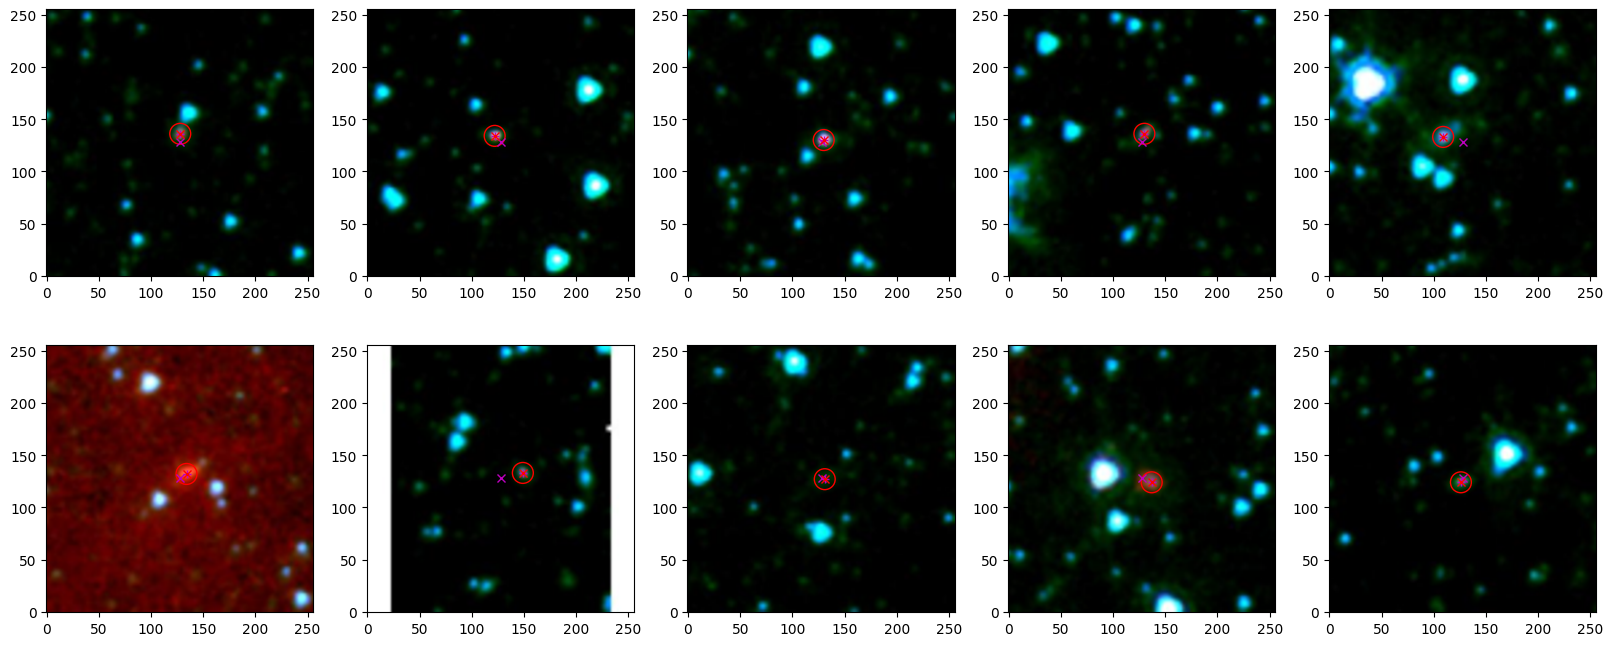

In [148]:
# Plot the image and the fitted ellipse
import matplotlib.pyplot as plt

s=4
fig, axes = plt.subplots(2, 5, figsize=(5*s, 2*s))
axes = axes.ravel()

for k in range(10):
  kk = k+23

  galaxy = catalog.loc[kk]
  im = Image.open(galaxy['file_loc'])
  im = im.resize((100,100))
  im = im.resize((256,256))

  img = np.array(im).sum(axis=2)
  #img = np.array(im)[:,:,0]
  result = refine_center(img)

  approx_center = result['approx_center']
  x_center, y_center = result['center']
  x_std, y_std = result['ellipse']['x_std'], result['ellipse']['y_std']
  theta = result['ellipse']['theta']
  a, b = result['ellipse']['a'], result['ellipse']['b']

  ax = axes[k]
  ax.imshow(im, origin='lower', cmap='gray')
  ax.add_patch(Ellipse((x_center, y_center), 2*a, 2*b, angle=np.degrees(theta), edgecolor='red', facecolor='none'))
  ax.plot(128,128, 'mx', label='Marked center')
  ax.plot(approx_center[0], approx_center[1], 'm+', label='Approx Center')
  ax.plot(x_center, y_center, 'rx', label='Fitted Center')
  #ax.legend()

In [145]:
  galaxy = catalog.loc[23]
  im = Image.open(galaxy['file_loc'])
  im = im.resize((100,100))
  im = im.resize((256,256))

  img = np.array(im).sum(axis=2)
  #img = np.array(im)[:,:,0]
  result = refine_center(img)

result

{'approx_center': (np.int64(128), np.int64(136)),
 'center': (np.float64(220.16623173129832), np.float64(345.39721488990205)),
 'ellipse': {'x_std': np.float64(5.044032417161457),
  'y_std': np.float64(62.534760798718445),
  'theta': np.float64(-0.4173556446767256),
  'a': np.float64(10.088064834322914),
  'b': np.float64(125.06952159743689)}}

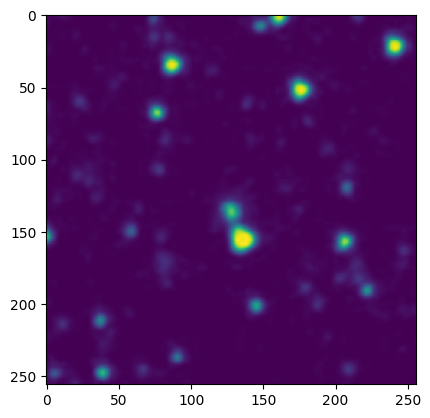

In [146]:
plt.imshow(img)

In [149]:
# Process the catalog and refine the center
from tqdm import tqdm
for k in tqdm(catalog.index):
  galaxy = catalog.loc[k]
  im = Image.open(galaxy['file_loc'])
  im = im.resize((100,100))
  im = im.resize((256,256))

  img = np.array(im).sum(axis=2)
  #img = np.array(im)[:,:,0]
  result = refine_center(img)

  if (result is None):
    center = (None, None)
  else:
    center = result['center']
  catalog.loc[k, 'center_x'] = center[0]
  catalog.loc[k, 'center_y'] = center[1]

 20%|██        | 288/1425 [00:01<00:08, 134.10it/s]/tmp/ipykernel_5718/2566309350.py:10: RuntimeWarning: divide by zero encountered in divide
  normalized_im = img / np.max(img[128-20:128+20, 128-20:128+20])
/tmp/ipykernel_5718/2566309350.py:10: RuntimeWarning: invalid value encountered in divide
  normalized_im = img / np.max(img[128-20:128+20, 128-20:128+20])
 21%|██        | 302/1425 [00:02<00:08, 133.68it/s]WARNING: NoDetectionsWarning: Input data is constant. No local peaks can be found. [photutils.detection.peakfinder]
/tmp/ipykernel_5718/2566309350.py:10: RuntimeWarning: divide by zero encountered in divide
  normalized_im = img / np.max(img[128-20:128+20, 128-20:128+20])
/tmp/ipykernel_5718/2566309350.py:10: RuntimeWarning: invalid value encountered in divide
  normalized_im = img / np.max(img[128-20:128+20, 128-20:128+20])
 35%|███▍      | 497/1425 [00:03<00:06, 135.21it/s]/tmp/ipykernel_5718/2566309350.py:10: RuntimeWarning: divide by zero encountered in divide
  normalized_i

In [151]:
pd.isna(catalog.center_x).sum()

np.int64(39)

In [129]:
catalog.index

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424],
      dtype='int64', length=1425)

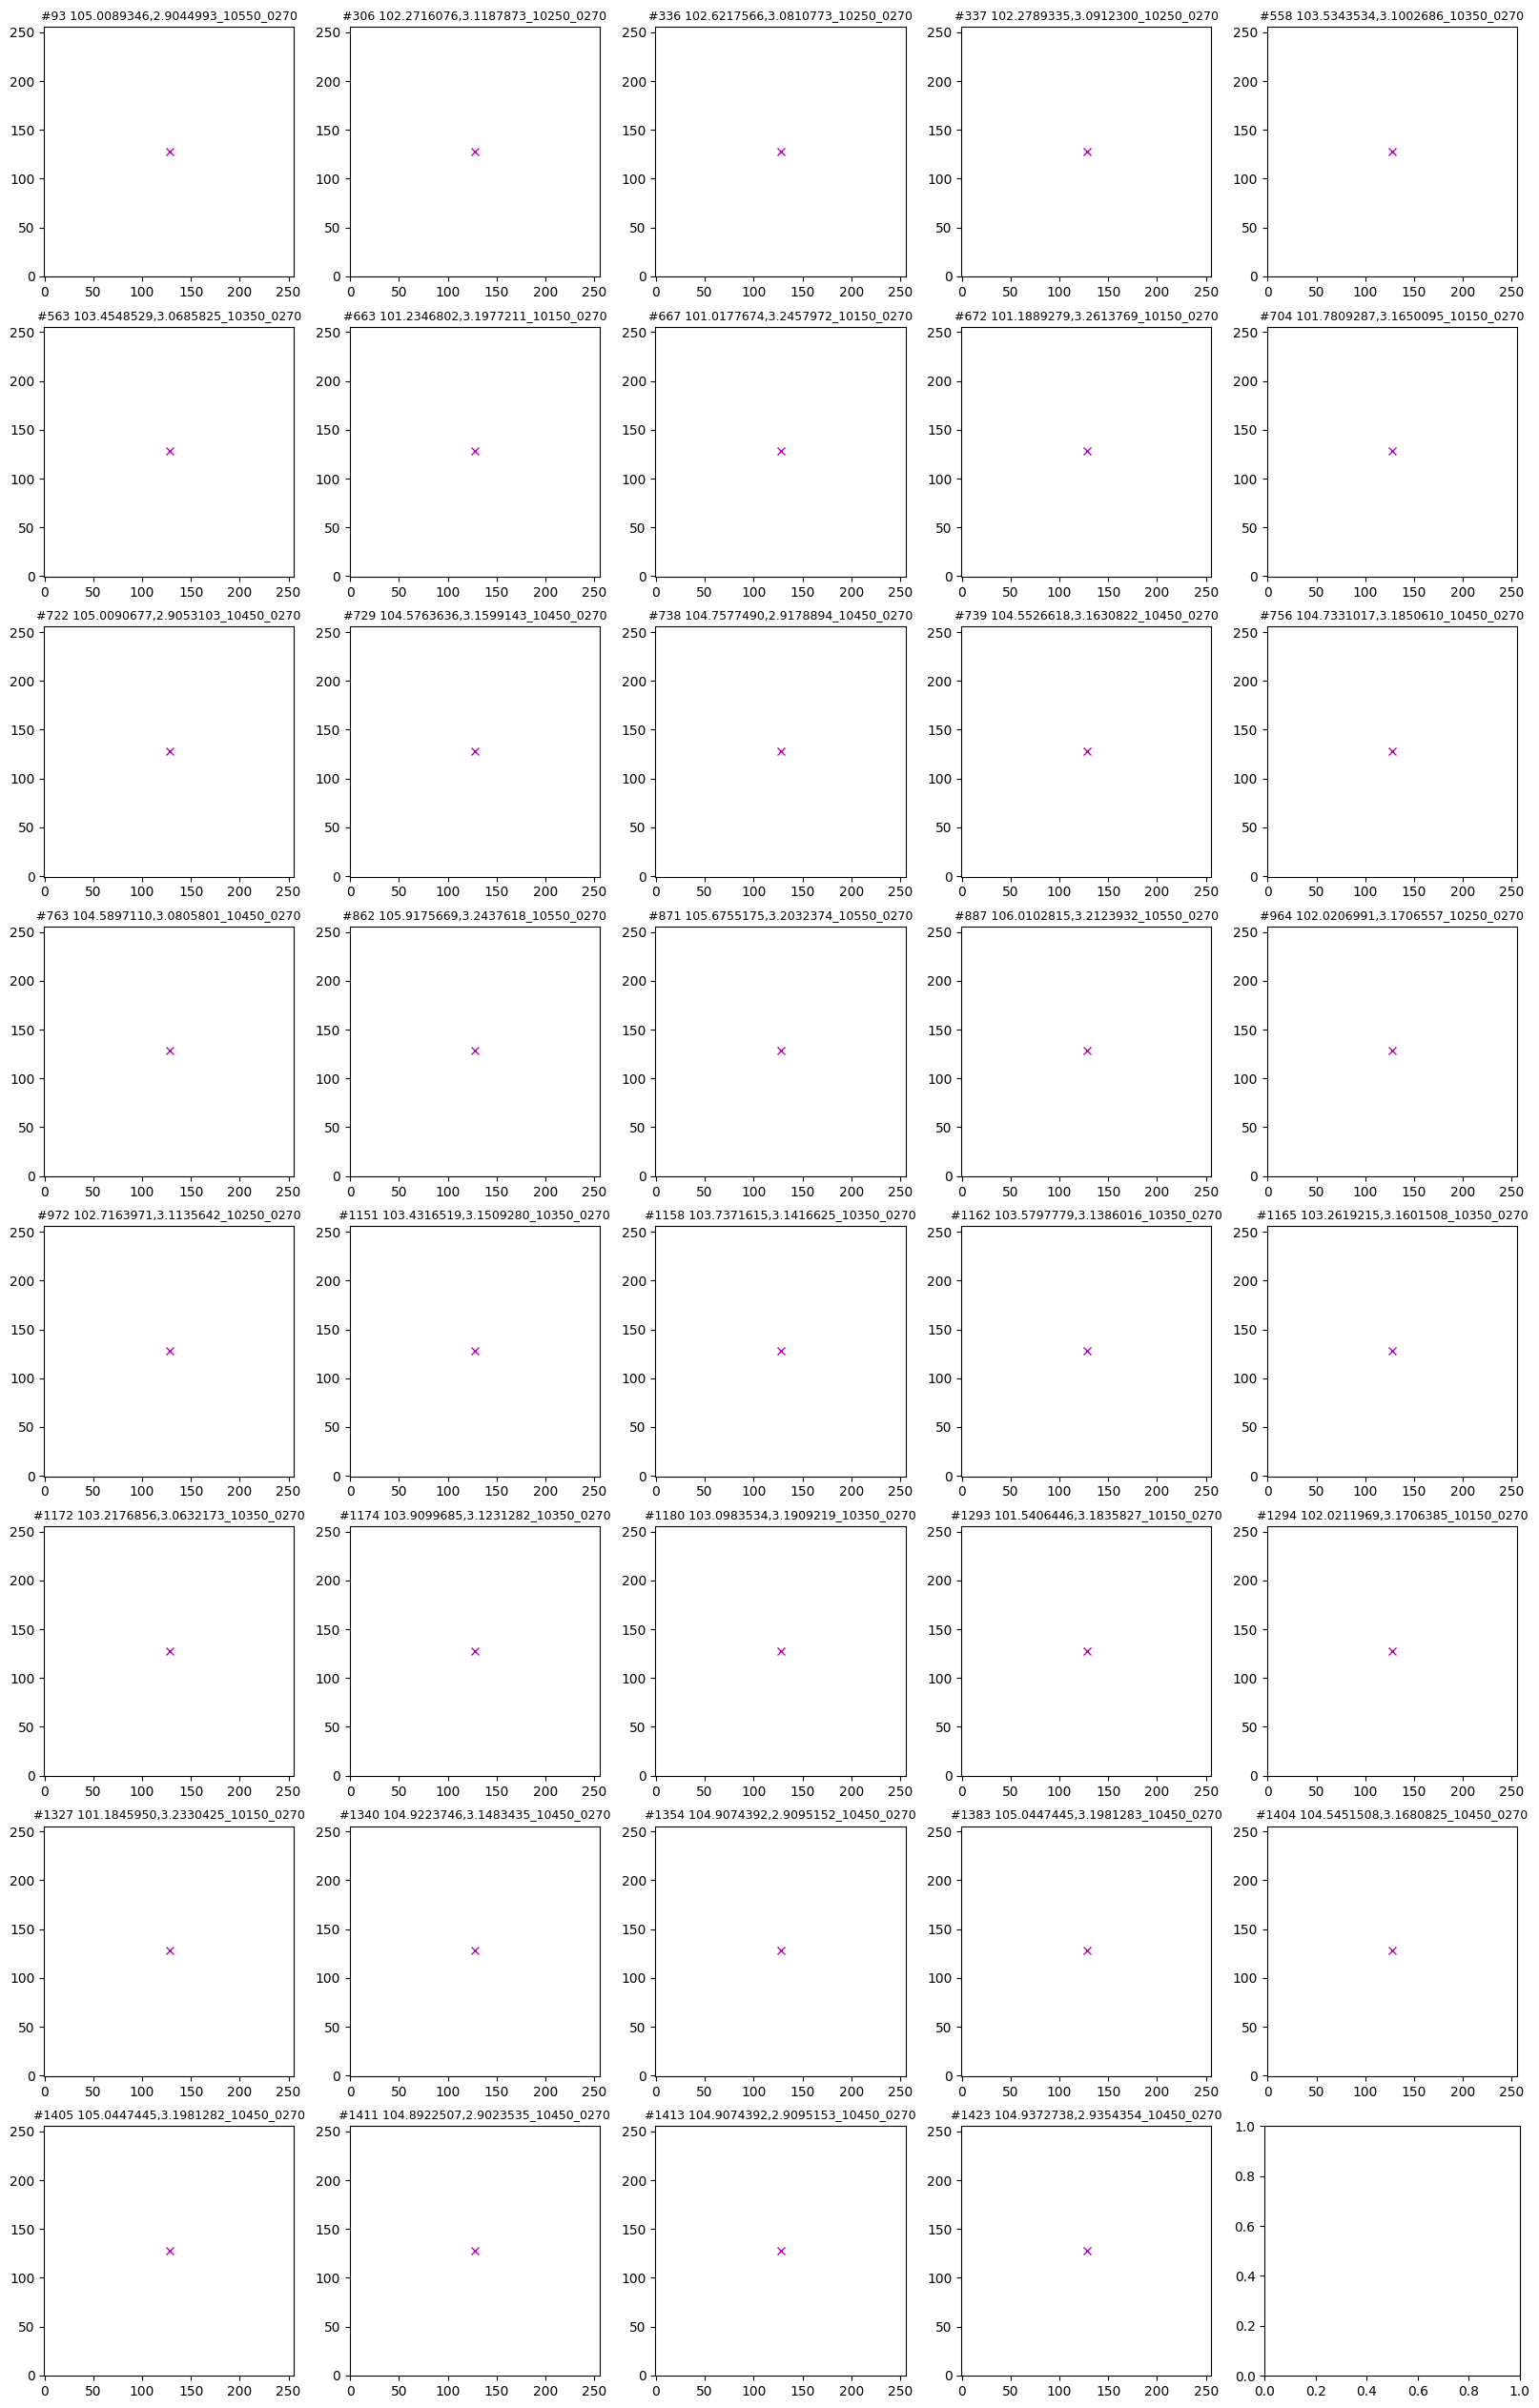

In [156]:
s=4
ny,nx = 8,5
fig, axes = plt.subplots(ny, nx, figsize=(nx*s, ny*s))
axes = axes.ravel()

for k,kk in enumerate(catalog[pd.isna(catalog.center_x)].index):
  if (k>=nx*ny): break;
  galaxy = catalog.loc[kk]
  im = Image.open(galaxy['file_loc'])
  im = im.resize((100,100))
  im = im.resize((256,256))

  img = np.array(im).sum(axis=2)
  #img = np.array(im)[:,:,0]
  result = refine_center(img)

  if (result is not None):
    approx_center = result['approx_center']
    x_center, y_center = result['center']
    x_std, y_std = result['ellipse']['x_std'], result['ellipse']['y_std']
    theta = result['ellipse']['theta']
    a, b = result['ellipse']['a'], result['ellipse']['b']

  ax = axes[k]
  ax.imshow(im, origin='lower', cmap='gray')
  ax.plot(128,128, 'mx', label='Marked center')
  if (result is not None):
    ax.add_patch(Ellipse((x_center, y_center), 2*a, 2*b, angle=np.degrees(theta), edgecolor='red', facecolor='none'))
    ax.plot(approx_center[0], approx_center[1], 'm+', label='Approx Center')
    ax.plot(x_center, y_center, 'rx', label='Fitted Center')
  ax.set_title(f"#{kk} {catalog.loc[kk].id_str}", fontdict=dict(size=9))
  #ax.legend()

In [157]:
catalog['ignore'] = pd.isna(catalog.center_x)

In [160]:
(catalog.train & catalog.ignore).sum()

np.int64(31)

In [12]:
item = catalog.iloc[0]
'id_str' in item

True